In [5]:
import pandas as pd
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [14, 6]
import matplotlib.ticker as ticker
import seaborn as sns

In [6]:
# load data
df = pd.read_csv("./yahoo_change_data_3mon.csv")
df["Change%"] = df['Change%'].str.replace('%', '').astype('float')
display(df.head())

,Date,Open,High,Low,Close,Change%,Volume
0,1/2/2020,3244.669922,3258.139893,3235.530029,3257.850098,0.84,3.458250e+09
1,1/3/2020,3226.360107,3246.149902,3222.340088,3234.850098,-0.71,3.461290e+09
2,1/6/2020,3217.550049,3246.840088,3214.639893,3246.280029,0.35,3.674070e+09
3,1/7/2020,3241.860107,3244.909912,3232.429932,3237.179932,-0.28,3.420380e+09
4,1/8/2020,3238.590088,3267.070068,3236.669922,3253.050049,0.49,3.720890e+09


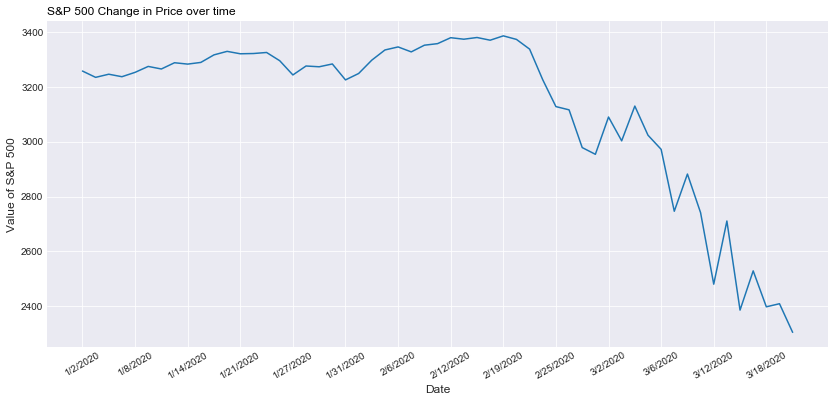

In [7]:
plt.style.use('seaborn-darkgrid')
fig, ax = plt.subplots()
ax.plot(df["Date"], df["Close"])
plt.xticks(rotation=30)
ax.set_xticks(ax.get_xticks()[::4])
plt.title("S&P 500 Change in Price over time", loc='left', fontsize=12, fontweight=0, color='black')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Value of S&P 500", fontsize=12)
plt.show()

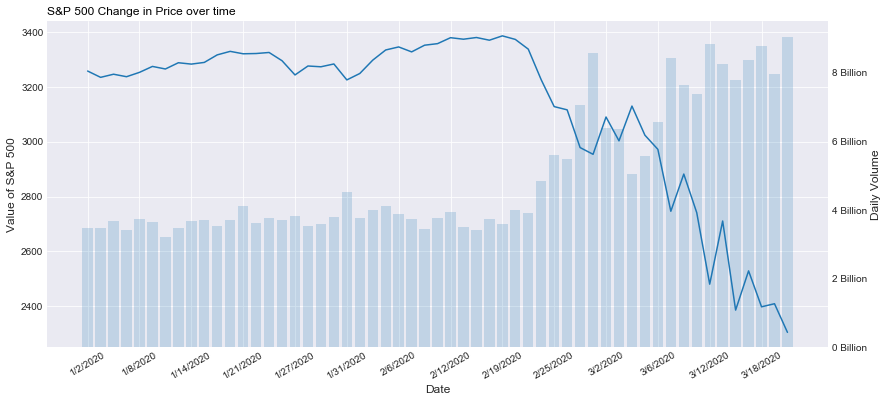

In [8]:
plt.style.use('seaborn-darkgrid')

# Graph 1
fig, ax1 = plt.subplots(figsize=(14, 6))
ax1.plot(df["Date"], df["Close"])

# Graph 2

ax2 = ax1.twinx()
ax2.grid(False)
ax2.bar(df["Date"], df["Volume"], alpha=0.2)
ax2.get_xaxis().set_visible(False)

# Plot settings
plt.setp( ax1.xaxis.get_majorticklabels(), rotation=30 )
ax2.set_xticks(ax2.get_xticks()[::4])
plt.title("S&P 500 Change in Price over time", loc='left', fontsize=12, fontweight=0, color='black')
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Value of S&P 500", fontsize=12)
ax2.set_ylabel("Daily Volume", fontsize=12)
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: str(x)[:1] + " Billion"))

plt.show()

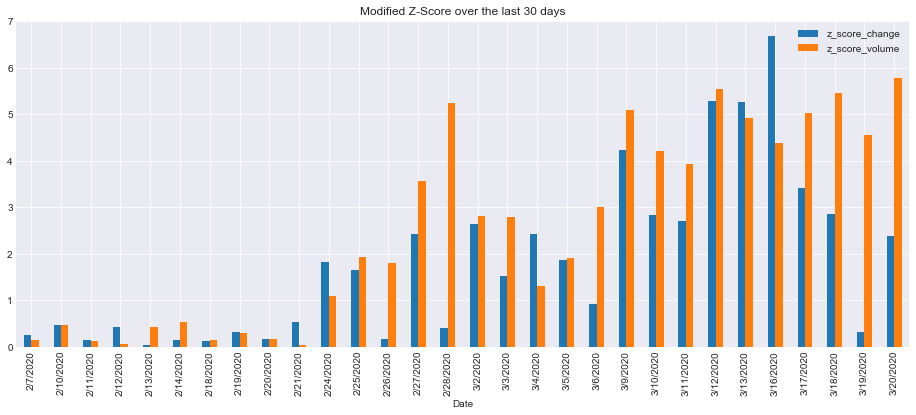

In [15]:
from statsmodels import robust

df_t = df

def mad(row, df_t, key):
    const = 0.6745
    data_point = row[key]
    median = df_t[key].median()
    med_abs_dev = robust.scale.mad(df_t[key])
    
    return abs(const * (data_point-median))/med_abs_dev

df_t["z_score_change"] = df_t.apply(lambda row: mad(row, df_t, "Change%"), axis=1)
df_t["z_score_volume"] = df_t.apply(lambda row: mad(row, df_t, "Volume"), axis=1)

df_t.tail(30).plot(x="Date", y=["z_score_change", "z_score_volume"], kind="bar", 
                   legend=True, title="Modified Z-Score over the last 30 days", figsize=(16, 6));

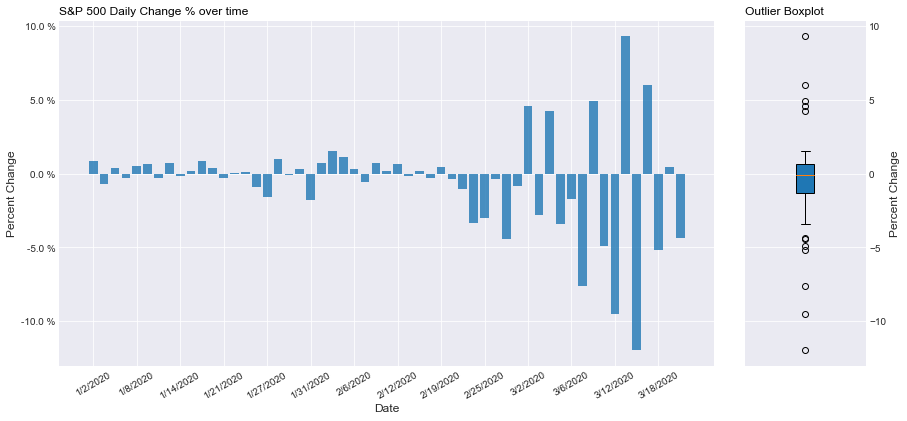

In [65]:
plt.style.use('seaborn-darkgrid')

# Graph 1
fig = plt.figure()
ax1 = fig.add_axes([0.1, 0.1, 0.65, 0.8])
ax2 = fig.add_axes([0.78, 0.1, 0.12, 0.8])
ax1.bar(df["Date"], df["Change%"], alpha=0.8)

# Graph 2
ax2.boxplot(df_t["Change%"], patch_artist=True)


# Plot settings
plt.setp( ax1.xaxis.get_majorticklabels(), rotation=30 )
ax1.set_xticks(ax1.get_xticks()[::4])
ax1.set_title("S&P 500 Daily Change % over time", loc='left', fontsize=12, fontweight=0, color='black')
ax2.set_title("Outlier Boxplot", loc='left', fontsize=12, fontweight=0, color='black')
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Percent Change", fontsize=12)
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: str(x) + " %"))
ax2.get_xaxis().set_visible(False)
ax2.yaxis.tick_right()
ax2.set_ylabel("Percent Change", fontsize=12)
ax2.yaxis.set_label_position("right")

plt.show()

In [68]:
# load data
df_2 = pd.read_csv("./list_drawdown.csv")
display(df_2)

,Drawdown Start,Drawdown Trading Days,Cumulative Drawdown Return,Drawdown Conclusion
0,7/17/1990,62,-19.18%,10/15/1990
1,10/8/1997,14,-10.75%,10/29/1997
2,7/20/1998,31,-19.19%,9/1/1998
3,7/19/1999,64,-11.80%,10/19/1999
4,9/5/2000,529,-47.41%,10/17/2002
5,10/10/2007,355,-55.25%,3/16/2009
6,7/21/2015,143,-12.96%,2/17/2016
7,9/20/2018,63,-19.80%,12/24/2018
8,2/19/2020,30,-31.90%,3/20/2020
